#Model definition


In [ ]:
import numpy as np
import torch
import torch.nn as nn

In [ ]:
!git clone https://github.com/PepeCamposGarcia/PINNs.git

In this case we consider a two dimensional flow past a cylinder, of which we know the exact velocity and pressure fields, obtained through precise numerical simulation. The aim of this model is to reconstruct these fields along all the spatio-temporal domain parting from a little fraction of the data. This flow is determined by the time-dependent, two-dimensional Navier-Stokes equations, with initial and boundary conditions. These equations are the following:
$$
    \begin{cases}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right), \\
     \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}  = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right), \\
     \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0,
    \end{cases}
$$

In [ ]:
class SinusoidalActivation(nn.Module):
  def forward(self,x):
    return torch.sin(2 * np.pi * x)

In [ ]:

class NavierStokesModel(nn.Module):

############################### NET ARCHITECTURE ###############################

  def __init__(self, num_neurons, num_layers, nu, rho):
    self.nu = nu
    self.rho = rho

    super(NavierStokesModel, self).__init__()
    self.num_neurons = num_neurons
    self.num_layers = num_layers

### Imput layer, fully connected to the first hidden layer, sinusoidal activation
### function for the dismiss of local minima

    layer_list = [nn.Linear(3, self.num_neurons)]
    layer_list.append(SinusoidalActivation())

### Loop for the description of the hidden layers, fully connected layers
### hiperbolic tangent activation function

    for _ in range (self.num_layers - 2):
      layer_list.append(nn.Linear(self.num_neurons, self.num_neurons))
      layer_list.append(nn.Tanh())

### Output layer, 3 outputs (u,v,p)

    layer_list.append(nn.Linear(self.num_neurons, 3))
    self.layers = nn.ModuleList(layer_list)


################## FEED-FORWARD PROPAGATION, OUTPUTS ###########################

  def forward(self, x, y, t):
     """
        Params:
        x - array of shape (N, 1), input x coordinates
        y - array of shape (N, 1), input y coordinates
        t - array of shape (N, 1), input time coordinate
        Returns:
        u - tensor of shape (N, 1), output x-velocity
        v - tensor of shape (N, 1), output y-velocity
        p - tensor of shape (N, 1), output pressure
        f - x-momentum PDE evaluation of shape (N, 1)
        g - y-momentum PDE evaluation of shape (N, 1)
        h - continuity PDE evaluation of shape (N, 1)

     """
     x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
     y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
     t = torch.tensor(t, dtype=torch.float32, requires_grad=True)

     input_data = torch.hstack([x, y, t])
     self.N = input_data.shape[0]

     out = input_data

     for layer in self.layers:
      out = layer(out)

     u, v, p = out[:, [0]], out[:, [1]], out[:, [2]] # (N, 1) each

     u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
     u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

     v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
     v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
     v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
     v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
     v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

     p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
     p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # Evaluate PDE's

     f = u_t + u * u_x + v * u_y + (1 / self.rho) * p_x - self.nu * (u_xx + u_yy) # (N, 1)
     g = v_t + u * v_x + v * v_y + (1 / self.rho) * p_y - self.nu * (v_xx + v_yy) # (N, 1)
     h = u_x + v_y

     return u, v, p, f, g, h


#Loss function

In [ ]:
##################### LOSS FUNCTION DESIGN #####################################

class NavierStokesLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()

  def forward(self, u, u_net, v, v_net, p, p_net, f, g, h):
     u = torch.tensor(u, dtype=torch.float32)
     v = torch.tensor(v, dtype=torch.float32)
     p = torch.tensor(p, dtype=torch.float32)

     L_data = self.mse(u, u_net) + self.mse(v, v_net) + self.mse(p, p_net)
     L_pde  = self.mse(f, torch.zeros_like(f)) + self.mse(g, torch.zeros_like(g)) + self.mse(h, torch.zeros_like(h))

     return L_data + L_pde

In [ ]:
import scipy

#Data loading


In [ ]:
def data_loading ():

  data = scipy.io.loadmat('/content/PINNs/Models_Data_Figures/Data/cylinder_wake.mat')
  U_star = data['U_star']  # N x 2 x T   5000 x 2 x 200
  P_star = data['p_star']  # N x T       5000 x 200
  t_star = data['t']       # T x 1       200  x 1
  X_star = data['X_star']  # N x 2       5000 x 2

  N, T= X_star.shape[0], t_star.shape[0]

### Dimension transformation into N x T

  XX = np.tile(X_star[:, [0]], (1, T))
  YY = np.tile(X_star[:, [1]], (1, T))
  TT = np.tile(t_star, (1, N)).T
  UU = U_star[:, 0, :]
  VV = U_star[:, 1, :]
  PP = P_star

### Column vector transformation dim NT x 1

  x_in = XX.flatten().reshape(-1, 1)  # NT x 1
  y_in = YY.flatten().reshape(-1, 1)  # NT x 1
  t_in = TT.flatten().reshape(-1, 1)  # NT x 1
  u_in = UU.flatten().reshape(-1, 1)  # NT x 1
  v_in = VV.flatten().reshape(-1, 1) # NT x 1
  p_in = PP.flatten().reshape(-1, 1) # NT x 1

  return x_in, y_in, t_in, u_in, v_in, p_in, (N, T)

In [ ]:
x_in, y_in, t_in, u_in, v_in, p_in, (N, T) = data_loading()

In [ ]:
from tqdm import tqdm

In [ ]:
def boundary_indices(N, T):
    """
    Returns a boolean mask marking the boundary condition for all timesteps
    Params:
    N - # of data samples (space locations) in problem
    T - # of timesteps
    Return:
    nd-array of shape (N*T, )
    """
    # Create grid for one timestep
    # Data is a 100 x 50 matrix for each timestep, each timestep constains
    # 296 boundary points out of the 5000 total, this function creates a boolean mask
    # to identify them over all timesteps

    grid_t_0 = np.zeros((50, 100))

    # Set boundary to 1
    grid_t_0[0, :] = 1
    grid_t_0[:, 0] = 1
    grid_t_0[-1, :] = 1
    grid_t_0[:, -1] = 1

    # Flatten grid into column vector and propagate for each timestep

    grid_t_in = np.tile(grid_t_0.reshape(-1, 1), (1, T)) # (N, T)

    # Flatten final grid into column vector to be used in training
    boundary_positions = grid_t_in.astype(bool).flatten() # (NT,1)

    return boundary_positions

#Training algorithm

In [ ]:
import csv

In [ ]:
def main(num_neurons, num_layers, epochs, train_selection):
    """
    Params:
    num_neurons - int, # of hidden units for each neural network layer
    num_layers - int, # of neural network layers
    epochs - int, # of training epochs
    train_selection - float, frac of all data (N*T) to select for training OR
                      'BC', select the boundary conditions for training (all timesteps)
    """
    # Load flattened cynlinder wake data
    x_in, y_in, t_in, u_in, v_in, p_in, (N, T) = data_loading () # (NT, 1)

    # Select training based on a fraction of an existing database or in boundary conditions

    if train_selection == 'BC':
        idx = boundary_indices(N, T)
    else:
        samples = int(round(N * T * train_selection))
        np.random.seed(0)
        idx = np.random.choice(x_in.shape[0], samples, replace=False)

    x_train = x_in[idx, :]
    y_train = y_in[idx, :]
    t_train = t_in[idx, :]
    u_train = u_in[idx, :]
    v_train = v_in[idx, :]
    p_train = p_in[idx, :]

    nu = 0.01
    rho = 1

    PINN_model = NavierStokesModel(num_neurons=num_neurons, num_layers=num_layers, nu=nu, rho=rho)
    criterion = NavierStokesLoss()

    optimizer = torch.optim.LBFGS(PINN_model.parameters(), line_search_fn='strong_wolfe')

    def closure():
        """Define closure function to use with LBFGS optimizer"""
        optimizer.zero_grad()   # Clear gradients from previous iteration

        u_net, v_net, p_net, f, g, h = PINN_model(x_train, y_train, t_train)
        loss = criterion(u_train, u_net, v_train, v_net, p_train, p_net, f, g, h)

        loss.backward() # Backprogation
        return loss

    def training_loop(epochs):
        """Run full training loop"""

        with open('losses_NavierStokes.csv', 'w', newline='') as csvfile:

          writer = csv.writer(csvfile)
          writer.writerow(['Epoch', 'Loss'])

          for i in tqdm(range(epochs), desc='Training epochs: '):

            optimizer.step(closure)
            loss = closure().item()
            writer.writerow([i + 1, loss])

    training_loop(epochs=epochs)

    torch.save(PINN_model.state_dict(), 'model_name.pth')
    return

Running the following cell will start the network training, generating a .pth file named 'model_name.pth', with the width and depth specified in 'num_neurons' and 'num_layers', and trained over 'epochs' iterations. The training set used is determined by the input 'train_selection'. Also, a .csv file named losses_NavierStokes.csv is generated. This file contains the evolution of the value the loss function takes along the training iterations.

In [ ]:
if __name__ == '__main__':
    main(num_neurons=num_neurons, num_layers=num_layers, epochs=epochs, train_selection=train_selection)

#Loss function representation


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

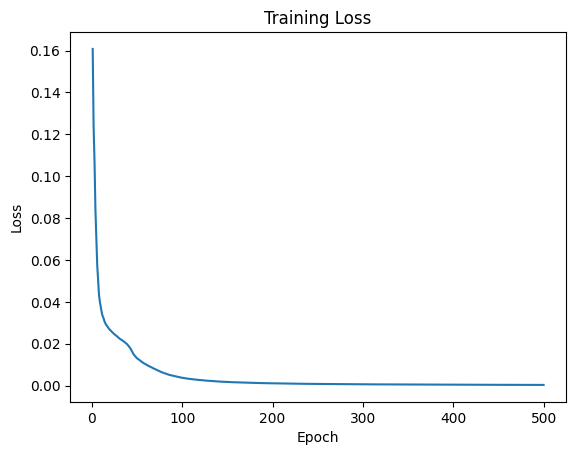

In [ ]:
def plot_loss_from_csv(file_path):
    epochs = []
    losses = []

    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            epoch, loss = map(float, row)
            epochs.append(epoch)
            losses.append(loss)

    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

plot_loss_from_csv('/content/PINNs/Models_Data_Figures/NAVIERSTOKES/Direct/losses_NavierStokes.csv')

#Predicted flow field evaluation

In [ ]:
x_in, y_in, t_in, u_in, v_in, p_in, (N, T) = data_loading()
# Separate N and T dimensions
XX = x_in.reshape(N, T)
YY = y_in.reshape(N, T)
TT = t_in.reshape(N, T)
UU = u_in.reshape(N, T)
VV = v_in.reshape(N, T)
PP = p_in.reshape(N, T)

def load_saved_model(num_layers, num_neurons):
    """
    Params:
    num_neurons - int, # of hidden units for each neural network layer
    num_layers - int, # of neural network layers

    """
    nu = 0.01
    rho = 1

    # load saved state_dict
    PINN_model = NavierStokesModel(num_neurons=num_neurons, num_layers=num_layers, nu=nu, rho=rho)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/NAVIERSTOKES/Direct/Models/NavierStokesDirecto.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def model_prediction(model, t):
    """
    Evaluate the model at time t, i.e., at TT[:, [t]]
    Params:
    model - PyTorch model to evaluate
    t - int between 0 and T-1, time index to evaluate
    Return:
    np.array() of shape (N, )
    """
    # Get predictions timestep t
    net_output = model(XX[:, [t]], YY[:, [t]], TT[:, [t]])
    u_net, v_net, p_net = net_output[0], net_output[1], net_output[2]

    # Convert to numpy and flatten
    u_net, v_net, p_net = (u_net.detach().numpy().flatten(),
                            v_net.detach().numpy().flatten(),
                            p_net.detach().numpy().flatten())
    return u_net, v_net, p_net

Representation auxiliary functions

In [ ]:
def contourf_subplots(vel, vel_pred, p, p_net, range_dict, axes):
    """
    Create subplots of contourf plots for predicted and reference velocity (magnitude) and pressure
    Params:
    vel, vel_pred, p, p_net - np.array of shape (N, ), reference and predicted velocity magnitude and pressure
    range_dict - dict with keys 'vel' and 'p' containing tuples (vmin, vmax) for contour value ranges
    axes - axes to plot on
    """

    # Plot prediction contours
    axes[0, 0].set_title('Velocidad PINN')
    contour_vel_pred = axes[0, 0].contourf(vel_pred.reshape(50, 100), levels=30, cmap='jet',
                                           vmin=range_dict['vel'][0], vmax=range_dict['vel'][1])

    axes[0, 1].set_title('Presión PINN')
    contour_p_net = axes[0, 1].contourf(p_net.reshape(50, 100), levels=30, cmap='jet',
                                         vmin=range_dict['p'][0], vmax=range_dict['p'][1])

    axes[1, 0].set_title('Velocidad de referencia')
    contour_vel = axes[1, 0].contourf(vel.reshape(50, 100), levels=30, cmap='jet',
                                      vmin=range_dict['vel'][0], vmax=range_dict['vel'][1])

    axes[1, 1].set_title('Presión de referencia')
    contour_p = axes[1, 1].contourf(p.reshape(50, 100), levels=30, cmap='jet',
                                    vmin=range_dict['p'][0], vmax=range_dict['p'][1])

    return [contour_vel, contour_vel_pred, contour_p, contour_p_net]



In [ ]:
def flow_field(model, title=''):
    """
    Params:
    model - PyTorch model to evaluate
    """
    # Set up plot
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 5), sharex=True, sharey=True)

    # Get predictions at first timestep
    u_net_0, v_net_0, p_net_0 = model_prediction(model=model, t=0) # Each of shape (N, )

    # Predicted and reference velocity magnitude at first timestep
    vel_net_0, vel_0 = np.sqrt(u_net_0 ** 2 + v_net_0 ** 2), np.sqrt(UU[:, 0] ** 2 + VV[:, 0] ** 2)

    # Max/min predicted OR reference velocity and pressure (for colorbar)
    max_vel, min_vel = np.concatenate([vel_0, vel_net_0]).max(), np.concatenate([vel_0, vel_net_0]).min()
    max_p, min_p = np.concatenate([PP[:, 0], p_net_0]).max(), np.concatenate([PP[:, 0], p_net_0]).min()
    range_dict = {'vel':(min_vel, max_vel), 'p':(min_p, max_p)} # dict for contourf_suplots function

    # Initial contour subplot at first timestep
    contours_0 = contourf_subplots(vel_0, vel_net_0, PP[:, 0], p_net_0, range_dict=range_dict, axes=axes)

    # Create figure labels, colobar
    axes[0, 0].set_aspect('equal')
    axes[1, 0].set_aspect('equal')
    axes[0, 1].set_aspect('equal')
    axes[1, 1].set_aspect('equal')

    fig.colorbar(contours_0[0], ax=[axes[0, 0], axes[1, 0]], orientation='vertical', shrink=0.45)
    fig.colorbar(contours_0[2], ax=[axes[0, 1], axes[1, 1]], orientation='vertical', shrink=0.45)
    fig.supxlabel(r'$x$')
    fig.supylabel(r'$y$')
    fig.suptitle(title)

    # Animate future timesteps
    def animate(i):
        [ax.clear() for ax in axes.flatten()]

        # Get predictions at timestep i
        u_net_i, v_net_i, p_net_i = model_prediction(model=model, t=i) # each of shape (N, )

        # Predicted and reference velocity magnitude at timestep i
        vel_net_i, vel_i = np.sqrt(u_net_i ** 2 + v_net_i ** 2), np.sqrt(UU[:, i] ** 2 + VV[:, i] ** 2)

        # Contourf subplots at timestep i
        contours_i = contourf_subplots(vel_i, vel_net_i, PP[:, [i]], p_net_i, range_dict=range_dict, axes=axes)

    ani = animation.FuncAnimation(fig, animate, 200, interval=1, blit=False)
    return ani

#Flow field representation

In [ ]:
modelnavierstokes = load_saved_model(num_layers=6, num_neurons=30)

%matplotlib notebook
ani = flow_field(modelnavierstokes)
from IPython.display import HTML
HTML(ani.to_jshtml())

The previous cell produces an animation of the flow throughout all timesteps, the following represents the initial instant.

<ipython-input-21-5f1a48a3d81d>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/NAVIERSTOKES/Dire

Text(0.02, 0.5, '$y$')

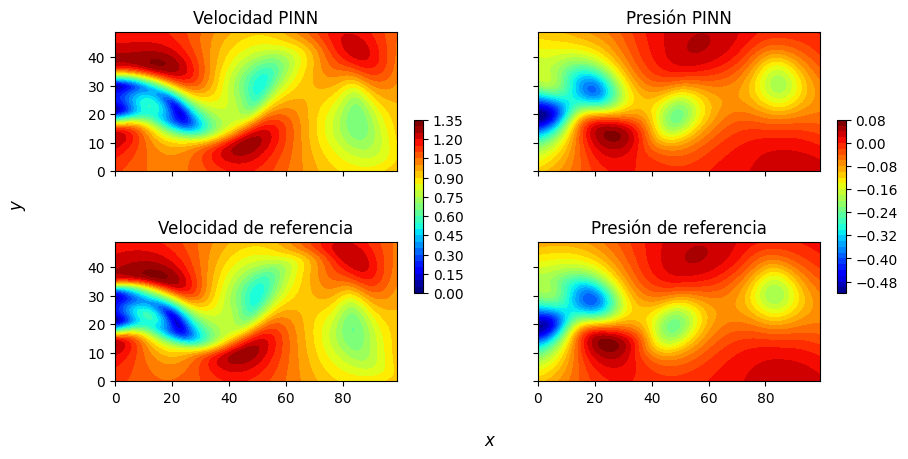

In [38]:
modelnavierstokes = load_saved_model(num_layers=6, num_neurons=30)

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 5), sharex=True, sharey=True)

# Get predictions at first timestep
u_net_0, v_net_0, p_net_0 = model_prediction(model=modelnavierstokes, t=0) # Each of shape (N, )

# Predicted and reference velocity magnitude at first timestep
vel_net_0, vel_0 = np.sqrt(u_net_0 ** 2 + v_net_0 ** 2), np.sqrt(UU[:, 0] ** 2 + VV[:, 0] ** 2)

# Max/min predicted OR reference velocity and pressure (for colorbar)
max_vel, min_vel = np.concatenate([vel_0, vel_net_0]).max(), np.concatenate([vel_0, vel_net_0]).min()
max_p, min_p = np.concatenate([PP[:, 0], p_net_0]).max(), np.concatenate([PP[:, 0], p_net_0]).min()
range_dict = {'vel':(min_vel, max_vel), 'p':(min_p, max_p)} # dict for contourf_suplots function

# Initial contour subplot at first timestep
contours_0 = contourf_subplots(vel_0, vel_net_0, PP[:, 0], p_net_0, range_dict=range_dict, axes=axes)

# Create figure labels, colobar
axes[0, 0].set_aspect('equal')
axes[1, 0].set_aspect('equal')
axes[0, 1].set_aspect('equal')
axes[1, 1].set_aspect('equal')

fig.colorbar(contours_0[0], ax=[axes[0, 0], axes[1, 0]], orientation='vertical', shrink=0.45)
fig.colorbar(contours_0[2], ax=[axes[0, 1], axes[1, 1]], orientation='vertical', shrink=0.45)
fig.supxlabel(r'$x$')
fig.supylabel(r'$y$')


#Root mean squared error representation

In [ ]:
def plot_rmse_field(model, title=''):
    """
    Params:
    PyTorch model to evaluate
    """
     # Set up plot
    fig, axes = plt.subplots(ncols = 2, figsize=(10, 4), sharex=True, sharey=True)
    # Get predictions at first timestep
    u_net_0, v_net_0, p_net_0 = model_prediction(model=model, t=0) # Each of shape (N, )

    # Predicted and reference velocity magnitude
    vel_net_0, vel_0 = np.sqrt(u_net_0 ** 2 + v_net_0 ** 2), np.sqrt(UU[:, 0] ** 2 + VV[:, 0] ** 2)

    # Calculate RMSE
    v_rmse_0, p_rmse_0 = np.sqrt(((vel_net_0 - vel_0) ** 2)), np.sqrt(((p_net_0 - PP[:, 0]) ** 2))

    # Initial plot
    contour_vel = axes[0].contourf(v_rmse_0.reshape(50, 100), levels=30, cmap='jet')
    contour_p = axes[1].contourf(p_rmse_0.reshape(50, 100), levels=30, cmap='jet')

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    # Create figure labels, colorbar
    fig.colorbar(contour_vel, ax=axes[0], orientation='vertical', shrink=0.45)
    fig.colorbar(contour_p, ax=axes[1], orientation='vertical', shrink=0.45)
    fig.supxlabel(r'$x$')
    fig.supylabel(r'$y$')
    fig.suptitle(title)

    # Animate future timesteps
    def animate(i):
        [ax.clear() for ax in axes.flatten()]

        # Get predictions at timestep i
        u_net_i, v_net_i, p_net_i = model_prediction(model=model, t=i)

        # Predicted and reference velocity magnitude
        vel_net_i, vel_i = np.sqrt(u_net_i ** 2 + v_net_i ** 2), np.sqrt(UU[:, i] ** 2 + VV[:, i] ** 2)

        # Calculate RMSE
        v_rmse, p_rmse = np.sqrt(((vel_net_i - vel_i) ** 2)), np.sqrt(((p_net_i - PP[:, i]) ** 2))

        # Plot rmse at timestep i
        axes[0].set_title('RMSE Velocidad')
        contour_vel_pred = axes[0].contourf(v_rmse.reshape(50, 100), levels=30, cmap='jet')
        axes[1].set_title('RMSE Presión')
        contour_p_pred = axes[1].contourf(p_rmse.reshape(50, 100), levels=30, cmap='jet')
        axes[0].set_aspect('equal')
        axes[1].set_aspect('equal')

    ani = animation.FuncAnimation(fig, animate, 200, interval=1, blit=False)
    return ani

In [ ]:
modelnavierstokes = load_saved_model(num_layers=6, num_neurons=30)

%matplotlib notebook
ani = plot_rmse_field(modelnavierstokes)
from IPython.display import HTML
HTML(ani.to_jshtml())

The previous cell produces an animation of the RMSE throughout all timesteps, the following represents the initial instant.

Text(0.02, 0.5, '$y$')

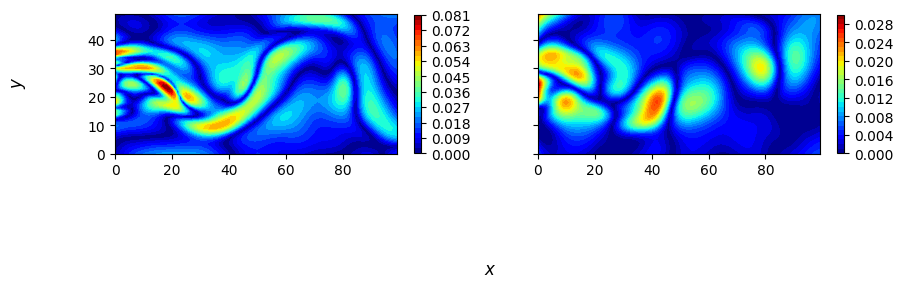

In [39]:
# Set up plot
fig, axes = plt.subplots(ncols = 2, figsize=(10, 4), sharex=True, sharey=True)
# Get predictions at first timestep
u_net_0, v_net_0, p_net_0 = model_prediction(model=modelnavierstokes, t=0) # Each of shape (N, )

# Predicted and reference velocity magnitude
vel_net_0, vel_0 = np.sqrt(u_net_0 ** 2 + v_net_0 ** 2), np.sqrt(UU[:, 0] ** 2 + VV[:, 0] ** 2)

# Calculate RMSE
v_rmse_0, p_rmse_0 = np.sqrt(((vel_net_0 - vel_0) ** 2)), np.sqrt(((p_net_0 - PP[:, 0]) ** 2))

# Initial plot
contour_vel = axes[0].contourf(v_rmse_0.reshape(50, 100), levels=30, cmap='jet')
contour_p = axes[1].contourf(p_rmse_0.reshape(50, 100), levels=30, cmap='jet')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# Create figure labels, colorbar
fig.colorbar(contour_vel, ax=axes[0], orientation='vertical', shrink=0.45)
fig.colorbar(contour_p, ax=axes[1], orientation='vertical', shrink=0.45)
fig.supxlabel(r'$x$')
fig.supylabel(r'$y$')


# Accuracy of prediction, R2 coefficient

In [ ]:
def rMSE(model):
    """
    Calculate root mean square error between the predictions and the DNS, over all data points (N) and all timesteps (T)
    Params:
    model - trained PINN model to evaluate

    Returns:
    rmse - array of shape (3, ) containing rmse for x-vel (u), y-vel (v), and pressure (p), respectively
    R2 - array of shape (3, ) containing corresponding R2 scores
    """
    # Initialize array to hold sum of square errors (SSE)
    sse = np.zeros((T, 3))

    for i in range(T):
        # Predictions for time i
        u_pred, v_pred, p_pred = model_prediction(model, t=i)
        # Save sum of square errors for time i
        sse[i, :] = [((u_pred - UU[:, i]) ** 2).sum(),
                     ((v_pred - VV[:, i]) ** 2).sum(),
                     ((p_pred - PP[:, i]) ** 2).sum()]

    # Sum sse over timesteps
    sse = sse.sum(axis=0) # (3, )
    # Average sse over all samples and all timesteps to get mse
    mse = sse / (N * T)

    # Find total sum of squares (SSTO)
    ssto = np.array([((u_in - u_in.mean()) ** 2).sum(), ((v_in - v_in.mean()) ** 2).sum(), ((p_in - p_in.mean()) ** 2).sum()])
    R2 = 1 - (sse / ssto)

    return np.sqrt(mse), R2

In [ ]:
rmse, r2 = rMSE(modelnavierstokes)
epoch_list = [500]
rmse_df, r2_df = pd.DataFrame(rmse.reshape(1,-1), columns=['u', 'v', 'p'], index=epoch_list), pd.DataFrame(r2.reshape(1,-1), columns=['u', 'v', 'p'], index=epoch_list)


In [ ]:
r2_df

,u,v,p
500,0.998674,0.999375,0.998871


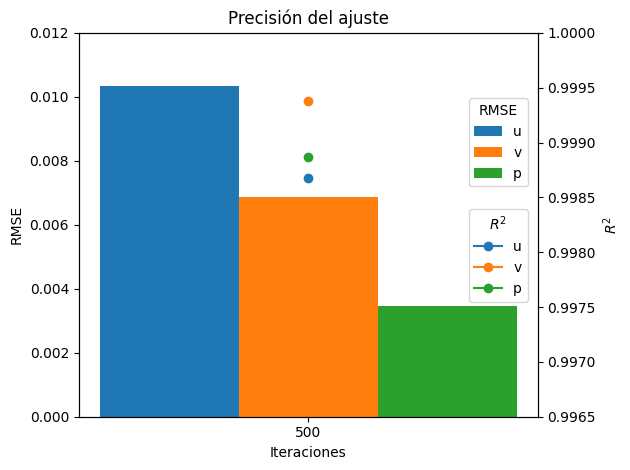

In [ ]:
%matplotlib inline
fig, ax1 = plt.subplots()

x = np.arange(1) # the label locations
width = 0.01 # the width of the bars

# Plot RMSE
ax1.bar(x - width, rmse_df['u'], width=width, label='u')
ax1.bar(x, rmse_df['v'], width=width, label='v')
ax1.bar(x + width, rmse_df['p'], width=width, label='p')

# Plot R2
ax2 = ax1.twinx()
ax2.plot(x, r2_df['u'], label='u', marker='o')
ax2.plot(x, r2_df['v'], label='v', marker='o')
ax2.plot(x, r2_df['p'], label='p', marker='o')
ax2.set_ylim(bottom=0.9965, top=1.0)

ax1.legend(loc=(0.85, 0.6), title='RMSE')
ax2.legend(loc=(0.85, 0.3), title='$R^2$')
ax1.set_ylim(bottom=0, top=0.012)
ax1.set_xticks(x, epoch_list)
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('$R^2$')
ax1.set_title('Precisión del ajuste')
plt.tight_layout()
